In [ ]:
!nvidia-smi

Sun Aug  4 00:07:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 320 (delta 21), reused 19 (delta 13), pack-reused 273
Receiving objects: 100% (320/320), 42.94 MiB | 22.20 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 116.3 kB/s eta 0:00:00
  Building edit

In [ ]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 14.1 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = f"{HOME}/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

/content/segment-anything-2/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
import base64
video_dir = "/content/clip"

for file in os.listdir(video_dir):
  filename = file.replace("frame", "")
  os.rename(os.path.join(video_dir, file), os.path.join(video_dir, filename))

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]


frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
# plt.figure(figsize=(12, 8))
# plt.title(f"frame {frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(video_dir + '/'+ frame_names[frame_idx])
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 49, 'y': 156, 'width': 0, 'height': 0, 'label': ''},
 {'x': 117, 'y': 156, 'width': 0, 'height': 0, 'label': ''},
 {'x': 193, 'y': 150, 'width': 0, 'height': 0, 'label': ''},
 {'x': 238, 'y': 138, 'width': 0, 'height': 0, 'label': ''},
 {'x': 387, 'y': 278, 'width': 0, 'height': 0, 'label': ''},
 {'x': 306, 'y': 197, 'width': 0, 'height': 0, 'label': ''},
 {'x': 235, 'y': 119, 'width': 0, 'height': 0, 'label': ''},
 {'x': 211, 'y': 159, 'width': 0, 'height': 0, 'label': ''},
 {'x': 279, 'y': 170, 'width': 0, 'height': 0, 'label': ''},
 {'x': 210, 'y': 100, 'width': 0, 'height': 0, 'label': ''}]

In [ ]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 300/300 [00:09<00:00, 31.33it/s]


In [ ]:
predictor.reset_state(inference_state)

In [ ]:
prompts = {}

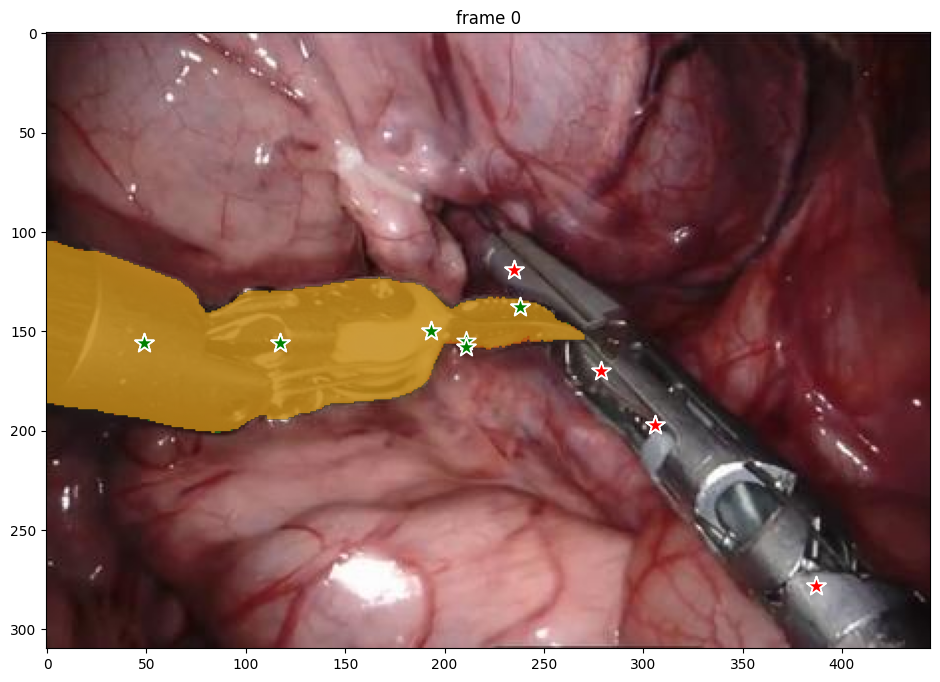

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[49,156],[117,156],[193,150],[238,138],[211,158],[387,278],[306,197],[235,119],[279,170]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,1,1,1,1,0,0,0,0], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

[{'x': 877, 'y': 672, 'width': 0, 'height': 0, 'label': ''},
 {'x': 907, 'y': 720, 'width': 0, 'height': 0, 'label': ''},
 {'x': 960, 'y': 697, 'width': 0, 'height': 0, 'label': ''},
 {'x': 994, 'y': 684, 'width': 0, 'height': 0, 'label': ''},
 {'x': 1005, 'y': 646, 'width': 0, 'height': 0, 'label': ''}]

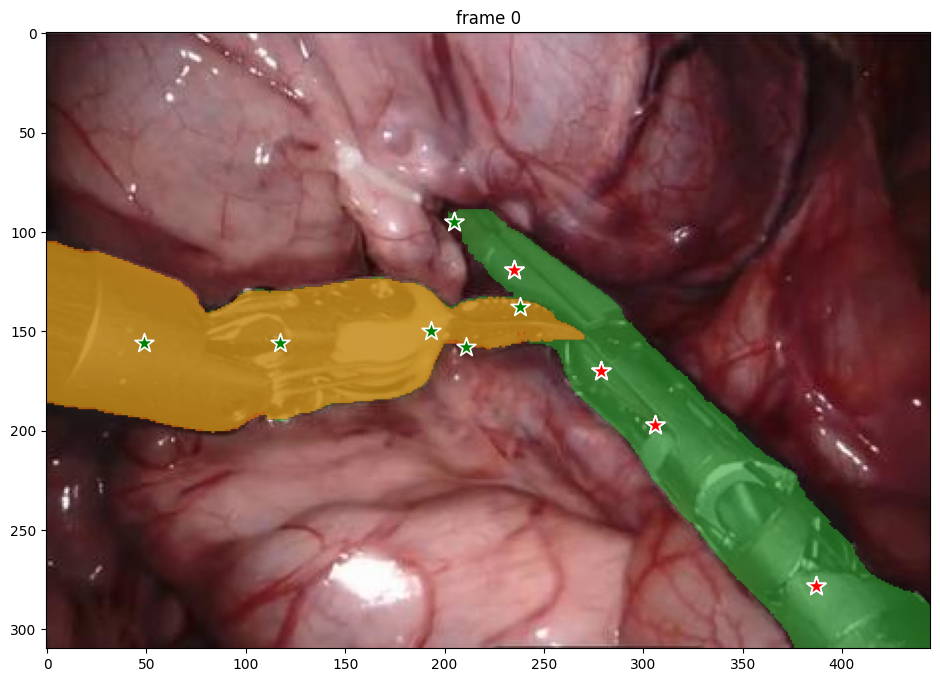

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)
points = np.array([[387,278],[306,197],[235,119],[279,170],[205,95]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,1,1,1,1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)


# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)



In [ ]:
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames


propagate in video: 100%|██████████| 300/300 [07:06<00:00,  1.42s/it]


In [ ]:

vis_frame_stride = 1
plt.close("all")
image_dir = 'clip_result'

for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    # plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))

    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)


    plt.axis("off")
    plt.savefig(f'{image_dir}/frame_{out_frame_idx:05d}.png')
    plt.close()








In [ ]:
import shutil

# Specify the folder to be zipped
folder_to_zip = 'clip_result'
output_filename = 'clip_result.zip'

# Zip the folder
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

print(f"{output_filename} has been created.")

clip_result.zip has been created.


In [ ]:
from google.colab import files

# Download the zip file
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>